<a href="https://colab.research.google.com/github/ar040701/DeepLearningProjects/blob/main/dinov2_withtrivial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 395.9/395.9 kB 23.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 247.0/247.0 kB 20.4 MB/s eta 0:00:00


In [2]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision.datasets import ImageFolder
import optuna
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns
from torch.utils.tensorboard import SummaryWriter

In [3]:
from torchvision import transforms
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [4]:
import zipfile
import os

zip_path = "/content/Places2_simp_resit.zip"
extract_path = "/content/Places2_simp_ayush"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

In [5]:
from torchvision.transforms import RandAugment,AutoAugment, AutoAugmentPolicy
from torchvision.transforms.v2 import TrivialAugmentWide

transform_train =  transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomAffine(degrees=20),
    TrivialAugmentWide(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

transforms_val = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [6]:
dataset_path = "/content/Places2_simp_ayush/Places2_simp"

dataset =  ImageFolder(root= dataset_path, transform= transform_train)
print(len(dataset))
print(len(dataset.classes))

40000
40


In [7]:
from torch.utils.data import random_split

training_size = int(0.8 * len(dataset))
validation_size = len(dataset) - training_size

train_dataset, val_dataset = random_split(dataset, [training_size, validation_size],  generator=torch.Generator().manual_seed(40))

In [8]:
val_dataset.dataset.transform = transforms_val
train_dataLoader = DataLoader(train_dataset, batch_size=100, shuffle=True)
val_dataLoader = DataLoader(val_dataset, batch_size=100, shuffle=False)

Feature batch shape: torch.Size([100, 3, 224, 224])
Labels batch shape: torch.Size([100])


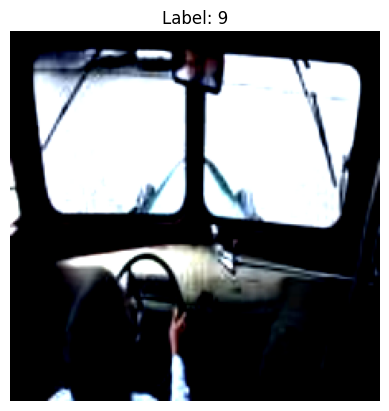

In [9]:
train_features, train_labels = next(iter(train_dataLoader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0].permute(1, 2, 0)
img = img * 0.5 + 0.5
label = train_labels[0]
plt.imshow(img.numpy())
plt.title(f"Label: {label}")
plt.axis("off")
plt.show()

In [10]:
dinov2 = torch.hub.load('facebookresearch/dinov2', 'dinov2_vitb14').to(device)
dinov2.eval()
num_classes = len(dataset.classes)

Downloading: "https://github.com/facebookresearch/dinov2/zipball/main" to /root/.cache/torch/hub/main.zip
/root/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/swiglu_ffn.py:51: UserWarning: xFormers is not available (SwiGLU)
  warnings.warn("xFormers is not available (SwiGLU)")
/root/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/attention.py:33: UserWarning: xFormers is not available (Attention)
  warnings.warn("xFormers is not available (Attention)")
/root/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/block.py:40: UserWarning: xFormers is not available (Block)
  warnings.warn("xFormers is not available (Block)")
Downloading: "https://dl.fbaipublicfiles.com/dinov2/dinov2_vitb14/dinov2_vitb14_pretrain.pth" to /root/.cache/torch/hub/checkpoints/dinov2_vitb14_pretrain.pth
100%|██████████| 330M/330M [00:01<00:00, 190MB/s]


In [11]:
class DinoClassifier(nn.Module):
    def __init__(self, dinov2_backbone, num_classes):
        super().__init__()
        self.backbone = dinov2_backbone
        self.classifier = nn.Linear(768, num_classes)

    def forward(self, x):
        with torch.no_grad():
             features_dict = self.backbone.forward_features(x)
             features = features_dict["x_norm_clstoken"]
        return self.classifier(features)

In [12]:
model = DinoClassifier(dinov2, num_classes)

model = model.to(device)

In [13]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=0.01)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.5)
epochs = 10

In [14]:
writer = SummaryWriter(log_dir="./runs/dinov2_trivialaug")

In [15]:
for epoch in range(epochs):
    print(f"Starting epoch {epoch+1}/{epochs}")
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for features, labels in train_dataLoader:
        features, labels = features.to(device), labels.to(device)
        optimizer.zero_grad()

        outputs = model(features)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    training_accuracy = correct / total if total > 0 else 0
    print(f"[Epoch {epoch+1}] Train Loss: {running_loss/len(train_dataLoader):.4f}, Accuracy: {training_accuracy*100:.2f}%")
    writer.add_scalar("Loss/train", running_loss/len(train_dataLoader), epoch)
    writer.add_scalar("Accuracy/train", training_accuracy, epoch)

    scheduler.step()

Starting epoch 1/10
[Epoch 1] Train Loss: 1.9411, Accuracy: 53.05%
Starting epoch 2/10
[Epoch 2] Train Loss: 0.9585, Accuracy: 74.69%
Starting epoch 3/10
[Epoch 3] Train Loss: 0.8020, Accuracy: 77.66%
Starting epoch 4/10
[Epoch 4] Train Loss: 0.7340, Accuracy: 79.07%
Starting epoch 5/10
[Epoch 5] Train Loss: 0.7049, Accuracy: 79.70%
Starting epoch 6/10
[Epoch 6] Train Loss: 0.6804, Accuracy: 80.22%
Starting epoch 7/10
[Epoch 7] Train Loss: 0.6604, Accuracy: 80.73%
Starting epoch 8/10
[Epoch 8] Train Loss: 0.6505, Accuracy: 80.97%
Starting epoch 9/10
[Epoch 9] Train Loss: 0.6413, Accuracy: 81.14%
Starting epoch 10/10
[Epoch 10] Train Loss: 0.6325, Accuracy: 81.39%


Top-1 Accuracy: 79.28%
Top-5 Accuracy: 96.99%


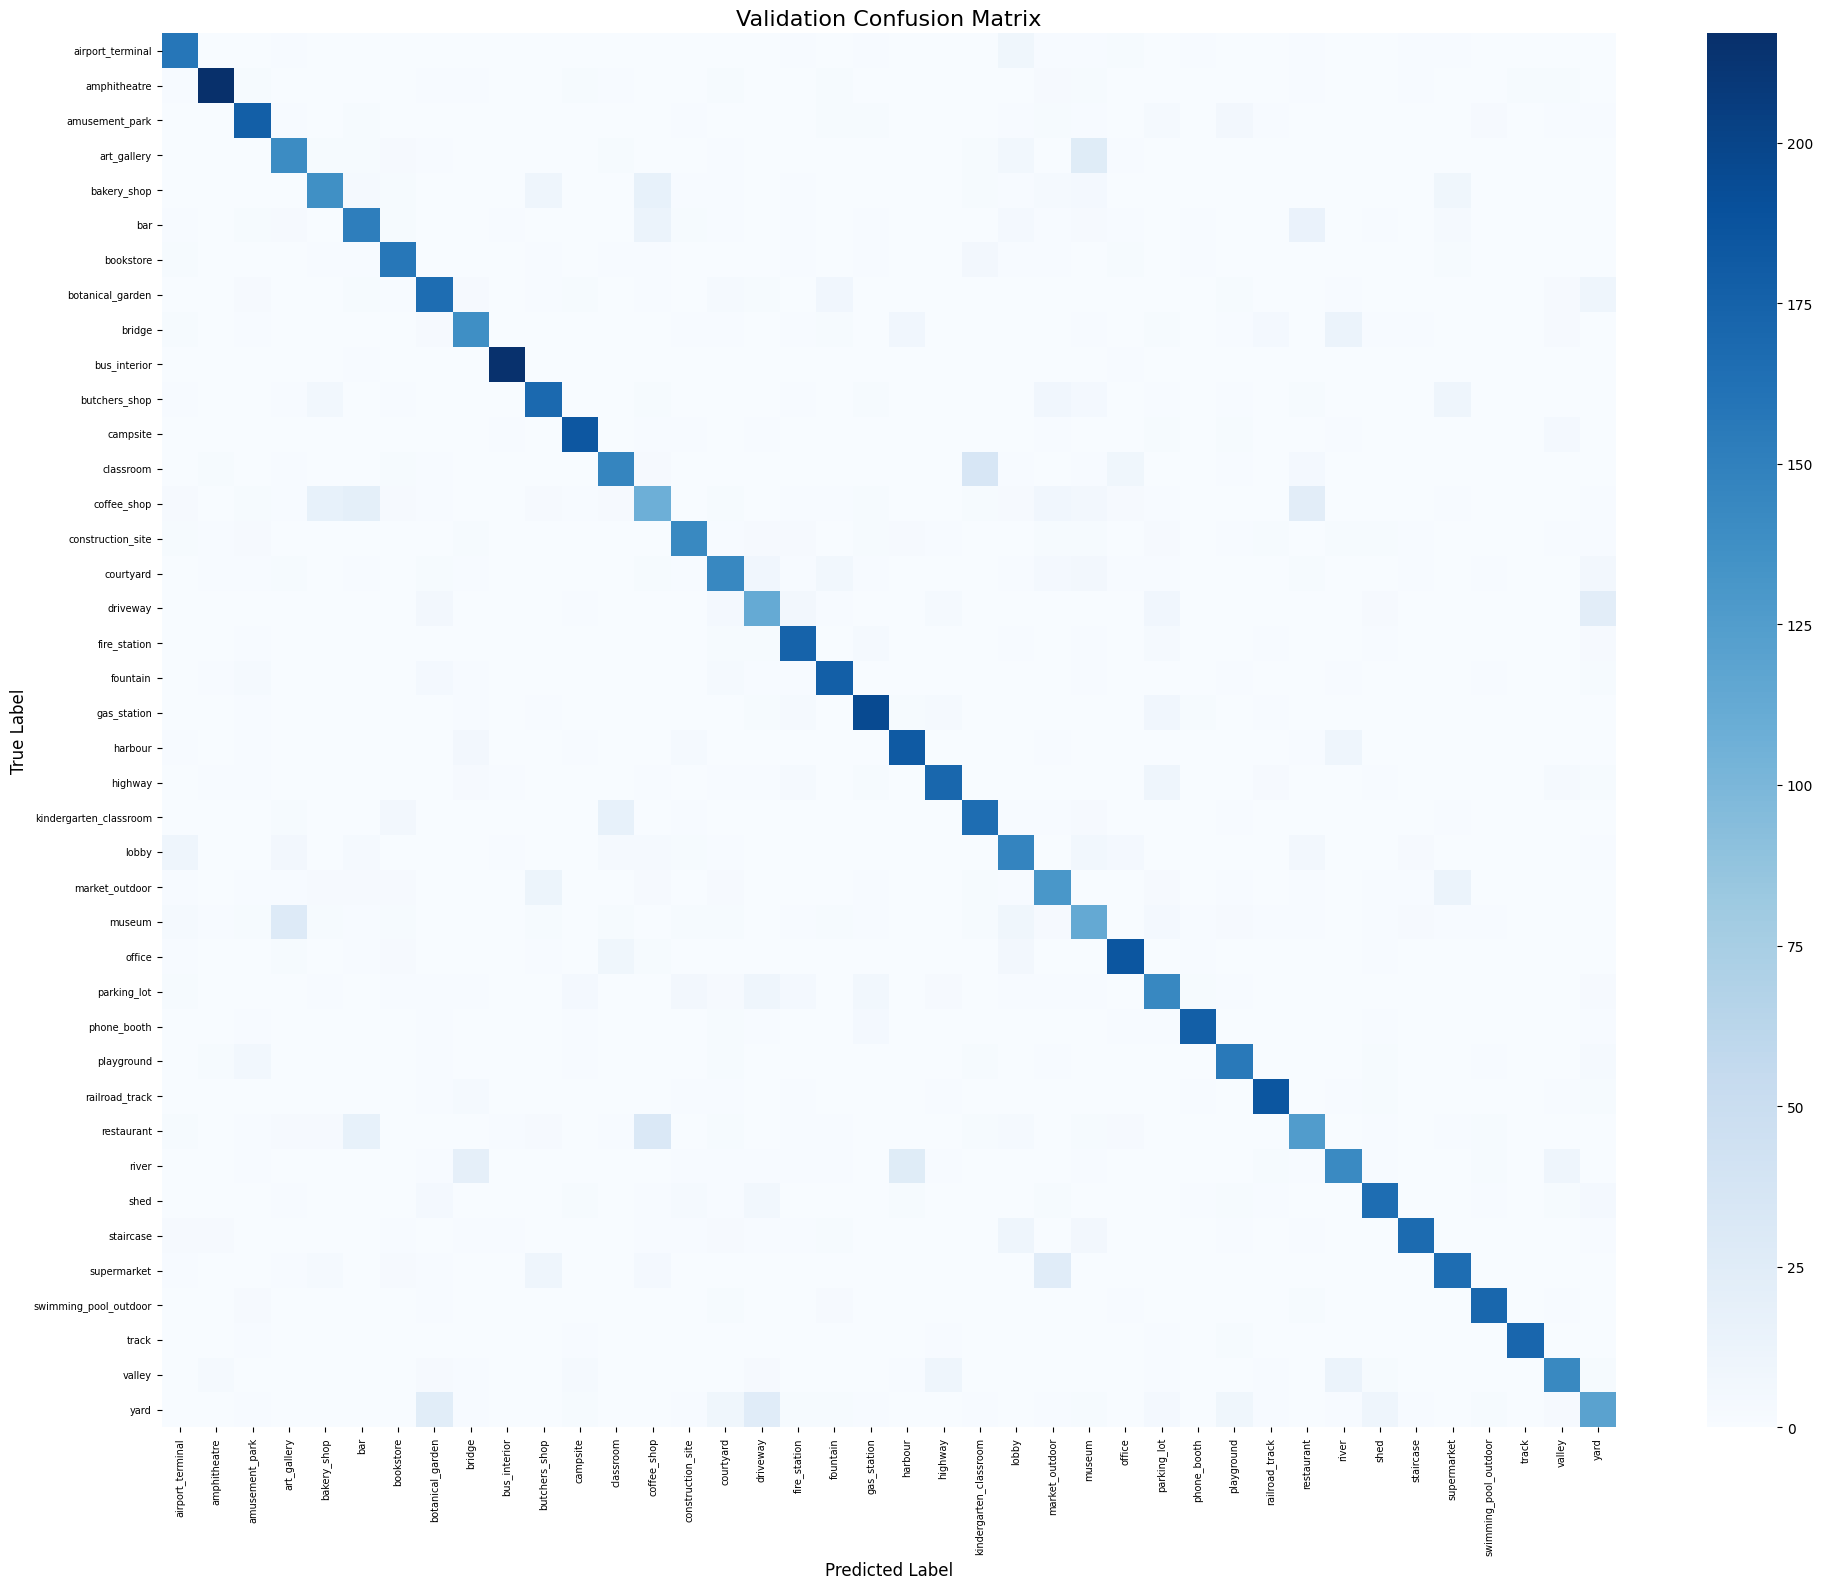

In [16]:
model.eval()
with torch.no_grad():
    top1_correct = 0
    top5_correct = 0
    total = 0
    all_labels = []
    all_preds = []

    for features, labels in val_dataLoader:
        features, labels = features.to(device), labels.to(device)
        outputs = model(features)
        total += labels.size(0)

        # Top-1
        predicted1 = outputs.topk(1, dim=1).indices.squeeze()
        top1_correct += (predicted1 == labels).sum().item()

        # Top-5
        top5_pred = outputs.topk(5, dim=1).indices
        for i in range(labels.size(0)):
            if labels[i] in top5_pred[i]:
                top5_correct += 1

        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(predicted1.cpu().numpy())

top1_acc = 100 * top1_correct / total
top5_acc = 100 * top5_correct / total

print(f"Top-1 Accuracy: {top1_acc:.2f}%")
print(f"Top-5 Accuracy: {top5_acc:.2f}%")

# Confusion matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(20, 16))
sns.heatmap(cm, annot=False, fmt='d', cmap='Blues',
            xticklabels=val_dataLoader.dataset.dataset.classes,
            yticklabels=val_dataLoader.dataset.dataset.classes)

plt.xticks(rotation=90, fontsize=7)
plt.yticks(rotation=0, fontsize=7)
plt.title("Validation Confusion Matrix", fontsize=16)
plt.xlabel("Predicted Label", fontsize=12)
plt.ylabel("True Label", fontsize=12)
plt.tight_layout()
plt.savefig("validation_confusion_matrix_trivialaug.png")
plt.show()

writer.close()